# Inferencia del modelo de CNN para la clasificación del estado de las calles
En este colab cargamos el modelo de CNN para hacer la inferencia del modelo que anteriormente entrenamos y guardamos su mejor peso, que en este caso fue de 87% asi que para ello cargamos el archivo, escribimos el cnn e hicimos una matriz de confusion asi como prueba con imagnes de testeo para verificar que tan eficiente fue el modelo

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
from datetime import datetime
import os
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

Integrantes:
Isabella Lopez
Luis Carlos Lozano
Camila Paz

In [25]:
#Conectamos el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# nos conectamos con la carpeta de runs, que se creo en el anterior colab, y es donde se guarda los resultados del mejor peso y los JSON respectivos
PROJECT_DIR = '/content/drive/MyDrive/proyecto_clase/runs'
PROJECT='/content/drive/MyDrive/proyecto_clase/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Aquí abrimos el archivo config.json que contiene todos los hiperparámetros
# que usamos cuando entrenamos el modelo: tamaño de imagen, batch size, etc
with open(f"{PROJECT_DIR}/config.json", "r") as f:
    config = json.load(f)

# Cargamos las clases del dataset. Este JSON simplemente tiene los nombres
# de las categorías en el mismo orden en que se entrenó el modelo.
with open(f"{PROJECT_DIR}/classes.json", "r") as f:
    class_names = json.load(f)

#Definimos el tamaño de la imagen, es el mismo que se uso en el entrenamiento, asi como el batch size

IMG_SIZE =config.get("img_size",244)
BATCH_SIZE = config.get("batch_size", 32)

#Ademas que Cargamos los valores de normalización que se usaron en entrenamiento.
mean =config.get("mean",[0.485, 0.456, 0.406])
std =config.get("std",[0.229, 0.224, 0.225])


# Definimos la transformación que se aplicará a las imágenes del test.
# 1. Se redimensionan al tamaño definido.
# 2. Se convierten a tensor.
# 3. Se normalizan con la media y desviación estándar del entrenamiento.
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Cargamos el dataset de test utilizando ImageFolder.
test_ds  = datasets.ImageFolder(f"{PROJECT}/data/test",  transform=eval_tf)
# Cargamos el DataLoader para el dataset de test.
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)



In [4]:
# Aquí definimos la arquitectura de la CNN que usamos en el entrenamiento. Es importante que sea exactamente igual a la del entrenamiento
# para que los pesos que cargamos funcionen correctamente.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
         # Dropout para reducir el sobreajuste en las capas densas.
        self.dropout = nn.Dropout(0.5)

        # Primera capa convolucional: recibe 3 canales (RGB) y genera 32 mapas de características.
        # El kernel es de 3x3, stride de 1 y padding de 1 para mantener tamaño.

        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2) # Reduce la resolución a la mitad.

        # Segunda convolución: ahora pasamos de 32 a 64 filtros.
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)

        # Tercera convolución: ampliamos a 128 filtros
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2)

       # Después de las 3 convoluciones y poolings, las imágenes quedan de tamaño 28x28
        # y tenemos 128 canales. Esto lo conectamos a una capa totalmente conectada.
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        # Segunda capa densa: ampliamos la representación a 512 neuronas.
        self.fc2 = nn.Linear(256, 512)
        # Capa de salida: tenemos 3 clases en nuestro problema.
        self.fc3 = nn.Linear(512, 3)

    def forward(self, x):
        # Pasamos por la primera convolución, activación ReLU y pooling.
        x = self.pool1(F.relu(self.conv1(x)))
        # Segunda conv -> ReLU -> pooling.
        x = self.pool2(F.relu(self.conv2(x)))
         # Tercera conv -> ReLU -> pooling.
        x = self.pool3(F.relu(self.conv3(x)))

        # Aplanar
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [5]:
# Aseguramos que exista la carpeta donde están los resultados del entrenamiento.
os.makedirs(PROJECT_DIR, exist_ok=True)
# Ruta en donde está guardado nuestro mejor modelo (.pth).
weights_path = f"{PROJECT_DIR}/model87.pth"

# Instanciamos la arquitectura del modelo y la enviamos al dispositivo disponible (GPU/CPU).
model=CNN().to(DEVICE)
# Cargamos los pesos entrenados. map_location asegura que funcionen aunque la GPU sea distinta.
state = torch.load(weights_path,map_location=DEVICE)
# Insertamos los pesos cargados dentro del modelo.
model.load_state_dict(state)
# Ponemos el modelo en modo evaluación
model.eval()

print("Modelo Cargado en",DEVICE)

Modelo Cargado en cpu


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


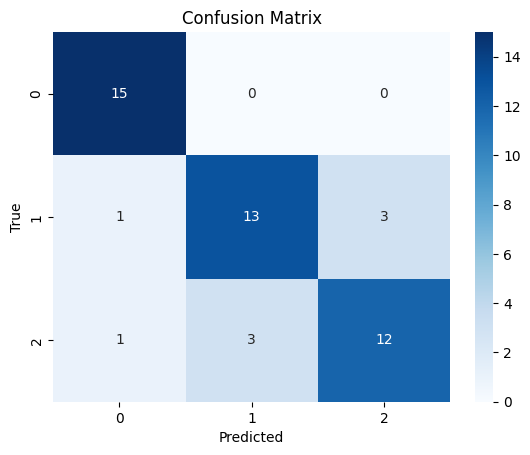

In [6]:
model.eval()  # modo evaluación
all_preds = [] # Aquí guardamos todas las predicciones.
all_labels = [] # Aquí guardamos todas las etiquetas reales.

# No calculamos gradientes porque no estamos entrenando.
with torch.no_grad():
    for images, labels in test_dl:
      # Pasamos el batch por el modelo.
        outputs = model(images)
       # Guardamos predicciones y etiquetas para análisis posterior.
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())    # guarda las predicciones
        all_labels.extend(labels.numpy())  # guarda las etiquetas reales

# Aqui creamos la matriz de confusion
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Imagen seleccionada: /content/drive/MyDrive/proyecto_clase/data/test/Grietas/Captura de pantalla 2025-10-15 093524.png


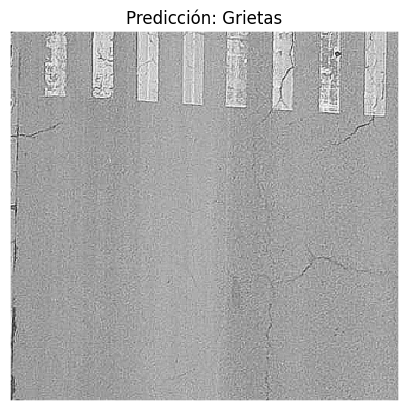

Predicción: Grietas
Probabilidades: [[0.05957833 0.78615594 0.15426572]]


In [23]:
# Ruta de las imagenes que usamos para probar la inferencia
test_folder  = "/content/drive/MyDrive/proyecto_clase/data/test"

# Se escoger una subcarpeta aleatoria
subfolders = [os.path.join(test_folder, d) for d in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, d))]
chosen_folder = random.choice(subfolders)

# Se escoge una imagen aleatoria dentro de esa carpeta
images = [os.path.join(chosen_folder, f) for f in os.listdir(chosen_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
img_path = random.choice(images)

print(f"Imagen seleccionada: {img_path}")

# Cargar imagen
img = Image.open(img_path).convert("RGB")

# Transformaciones (idénticas al entrenamiento)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Aplicar transformaciones
img_tensor = transform(img).unsqueeze(0).to(DEVICE)

# Predicción
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)

# Mostrar resultados
plt.imshow(img)
plt.title(f"Predicción: {class_names[predicted.item()]}")
plt.axis('off')
plt.show()

print(f"Predicción: {class_names[predicted.item()]}")
print(f"Probabilidades: {probs.cpu().numpy()}")

Al analizar los resultados de la inferencia observamos un desempeño bastante sólido en la clasificación, especialmente en la categoría “calle buena”, donde el modelo obtuvo probabilidades muy altas y predicciones consistentes. En el caso de las clases “grietas” y “huecos”, aunque también se lograron predicciones correctas en la mayoría de los casos, se presentaron algunos errores puntuales. Esto es completamente esperable, considerando que el modelo alcanzó una precisión global del 87%, por lo que cierto nivel de confusión entre clases con características visuales similares es normal.